# Telco Customer Churn Prediction

- Objective: Predict customer churn (the rate at which customers stop subscription) in a subscription-based business. 

- Goal: Create a model that can accurately identify customers likely to churn based on their usage and demographic data.

### Data Cleaning & Preparation

In [2]:
import pandas as pd
import numpy as np 
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from utils import missing_data

%matplotlib inline

In [3]:
df = pd.read_excel("data/Telco_customer_churn.xlsx")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
df.shape

(7043, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

### Customer Locations

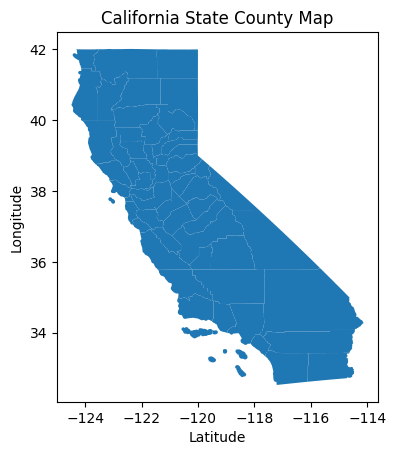

In [6]:
cali_map = gpd.read_file('data/CA_Shapefiles/CA_Counties.shp')
cali_map.to_crs(epsg=4326).plot()
plt.title('California State County Map')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [7]:
crs = {'init': 'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df,
                          crs=crs,
                          geometry=geometry)

/Users/sjo/miniforge3/envs/tensor/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [8]:
geo_df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,geometry
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,POINT (-118.27278 33.96413)
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,POINT (-118.30742 34.05928)
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved,POINT (-118.29395 34.04801)
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,POINT (-118.31571 34.06212)
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices,POINT (-118.26629 34.03922)


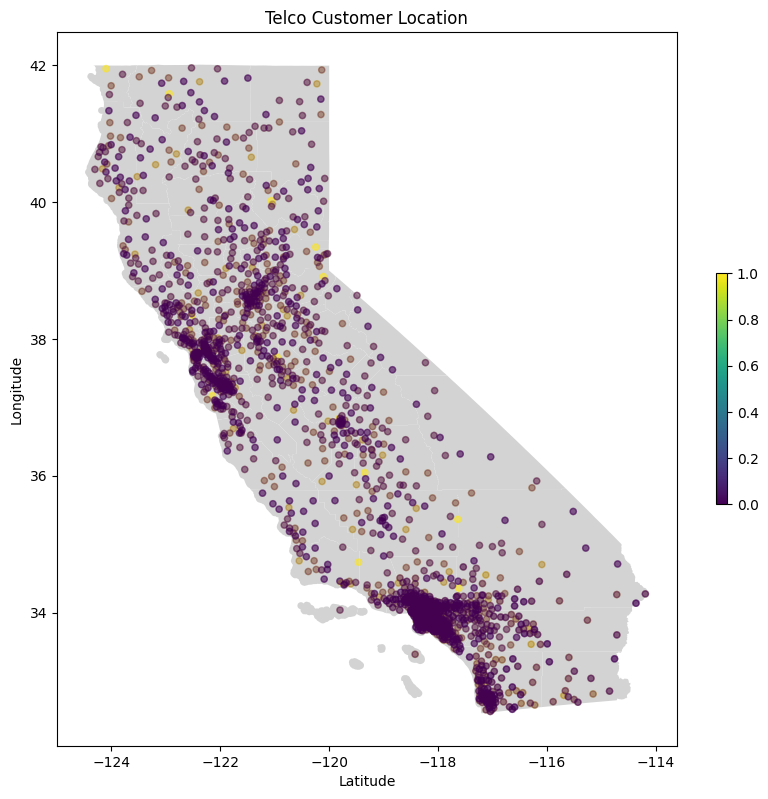

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
cali_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax, alpha=0.2, column='Churn Value',
            legend=True, legend_kwds={'shrink': 0.3}, markersize=20, cmap='viridis')
ax.set_title('Telco Customer Location')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

#### Churn Percentages

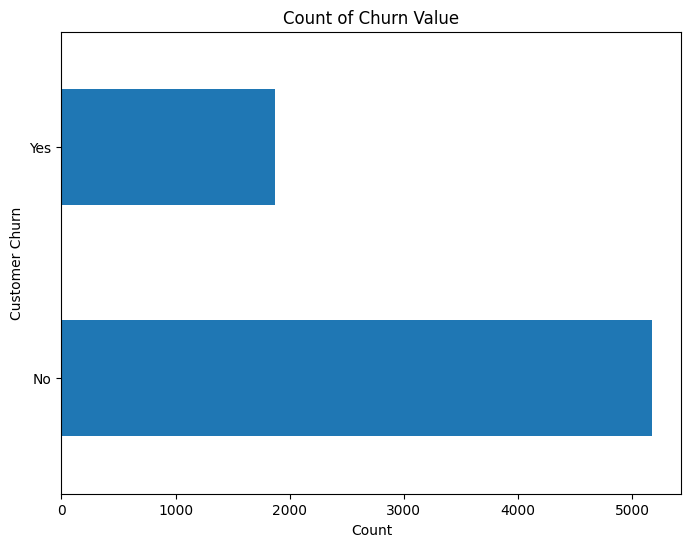

In [10]:
df['Churn Label'].value_counts().plot(kind='barh', figsize=(8,6))
plt.ylabel("Customer Churn")
plt.xlabel("Count")
plt.title("Count of Churn Value")
plt.show()

In [11]:
df['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

## Data Cleaning & Preparation

### Missing Data

In [12]:
missing_data(df)

,Total,Percent,Types
CustomerID,0,0.000000,object
Count,0,0.000000,int64
Country,0,0.000000,object
State,0,0.000000,object
City,0,0.000000,object
Zip Code,0,0.000000,int64
Lat Long,0,0.000000,object
Latitude,0,0.000000,float64
Longitude,0,0.000000,float64
Gender,0,0.000000,object


In [13]:
df_copy = df.copy()
df_copy.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [14]:
print(df_copy.shape)

(7043, 33)


#### Drop Repetative Columns

In [15]:
df_drop = df_copy.drop(columns=['Churn Reason', 'Country', 'State', 'Lat Long', 'Churn Label', 'CustomerID', 'Count'], axis=1)


In [16]:
df_drop.shape

(7043, 26)

In [17]:
missing_data(df_drop)

,Total,Percent,Types
City,0,0.0,object
Zip Code,0,0.0,int64
Latitude,0,0.0,float64
Longitude,0,0.0,float64
Gender,0,0.0,object
Senior Citizen,0,0.0,object
Partner,0,0.0,object
Dependents,0,0.0,object
Tenure Months,0,0.0,int64
Phone Service,0,0.0,object


In [18]:
df_drop['Total Charges'] = pd.to_numeric(
    df_drop['Total Charges'], errors='coerce')
print(df_drop['Total Charges'].isnull().sum())

11


In [19]:
mean = df_drop['Total Charges'].mean()
df_drop['Total Charges'] = df_drop['Total Charges'].fillna(mean)

In [20]:
df_drop['Total Charges'].isnull().sum()

0

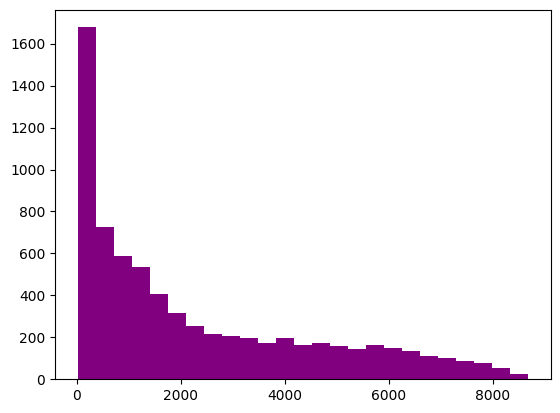

In [21]:
plt.hist(df_drop['Total Charges'], color='purple', bins=25)
plt.show()

## EDA

In [22]:
df_drop.describe()

,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,93521.964646,36.282441,-119.798880,32.371149,64.761692,2283.300441,0.265370,58.699418,4400.295755
std,1865.794555,2.455723,2.157889,24.559481,30.090047,2265.000258,0.441561,21.525131,1183.057152
min,90001.000000,32.555828,-124.301372,0.000000,18.250000,18.800000,0.000000,5.000000,2003.000000
25%,92102.000000,34.030915,-121.815412,9.000000,35.500000,402.225000,0.000000,40.000000,3469.000000
50%,93552.000000,36.391777,-119.730885,29.000000,70.350000,1400.550000,0.000000,61.000000,4527.000000
75%,95351.000000,38.224869,-118.043237,55.000000,89.850000,3786.600000,1.000000,75.000000,5380.500000
max,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000,100.000000,6500.000000


In [23]:
df_drop.columns.values

array(['City', 'Zip Code', 'Latitude', 'Longitude', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection',
       'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Value', 'Churn Score', 'CLTV'],
      dtype=object)

### Encode Categorical Columns

In [24]:
CAT_COLUMNS = ['Gender', 'Senior Citizen',
               'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'City',
               'Multiple Lines', 'Internet Service', 'Online Security',
               'Online Backup', 'Device Protection', 'Tech Support',
               'Streaming TV', 'Streaming Movies', 'Contract',
               'Paperless Billing', 'Payment Method']
NUM_COLUMNS = ['Count', 'Country', 'State',  'Zip Code', 'Latitude', 'Longitude', 'Monthly Charges',
               'Total Charges', 'Churn Value', 'Churn Score',
               'CLTV']

In [25]:
df_cat = pd.get_dummies(df_drop, columns=CAT_COLUMNS)
df_cat.head(10)

,Zip Code,Latitude,Longitude,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Gender_Female,Gender_Male,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,90003,33.964131,-118.272783,53.85,108.15,1,86,3239,False,True,...,False,True,False,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,70.70,151.65,1,67,2701,True,False,...,False,True,False,False,False,True,False,False,True,False
2,90006,34.048013,-118.293953,99.65,820.50,1,86,5372,True,False,...,True,True,False,False,False,True,False,False,True,False
3,90010,34.062125,-118.315709,104.80,3046.05,1,84,5003,True,False,...,True,True,False,False,False,True,False,False,True,False
4,90015,34.039224,-118.266293,103.70,5036.30,1,89,5340,False,True,...,True,True,False,False,False,True,True,False,False,False
5,90020,34.066367,-118.309868,55.20,528.35,1,78,5925,True,False,...,False,True,False,False,True,False,False,True,False,False
6,90022,34.023810,-118.156582,39.65,39.65,1,100,5433,False,True,...,True,True,False,False,False,True,False,False,True,False
7,90024,34.066303,-118.435479,20.15,20.15,1,92,4832,False,True,...,False,True,False,False,True,False,False,False,False,True
8,90028,34.099869,-118.326843,99.35,4749.15,1,77,5789,False,True,...,True,True,False,False,False,True,False,False,True,False
9,90029,34.089953,-118.294824,30.20,30.20,1,97,2915,False,True,...,False,True,False,False,True,False,False,False,True,False


In [26]:
df_cat.shape

(7043, 1253)

### Split Sets

In [27]:
X_train, X_, y_train, y_ = train_test_split(df_cat, df_cat['Churn Value'], test_size=0.4, random_state=43)

In [28]:
print(f'X_train Shape: {X_train.shape} \ny_train shape: {y_train.shape}')
print(f'X_ Shape: {X_.shape} \ny_ shape: {y_.shape}')

X_train Shape: (4225, 1253) 
y_train shape: (4225,)
X_ Shape: (2818, 1253) 
y_ shape: (2818,)


In [29]:
x_cv, x_test, y_cv, y_test = train_test_split(
    X_, y_, test_size=0.50, random_state=1)
del X_, y_

In [30]:
print(f'x_cv Shape: {x_cv.shape} \ny_cv shape: {y_cv.shape}')
print(f'x_test Shape: {x_test.shape} \ny_test shape: {y_test.shape}')

x_cv Shape: (1409, 1253) 
y_cv shape: (1409,)
x_test Shape: (1409, 1253) 
y_test shape: (1409,)


### Scale Numerical Columns

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(f"Computed mean of the training set: {scaler.mean_.squeeze()}")
print(f"Computed standard deviation of the training set: {scaler.scale_.squeeze()}")

Computed mean of the training set: [ 9.35349948e+04  3.62917103e+01 -1.19811476e+02 ...  2.20355030e-01
  3.35621302e-01  2.24852071e-01]
Computed standard deviation of the training set: [1.86263421e+03 2.46712976e+00 2.18028583e+00 ... 4.14486056e-01
 4.72207204e-01 4.17484871e-01]


In [32]:
x_cv_scaled = scaler.transform(x_cv)
x_test_scaled = scaler.transform(x_test)

## Baseline Model

### Logistic Regression

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve


In [34]:
sgd_classifier = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.01, max_iter=1000, tol=1e-3, random_state=42)

sgd_classifier.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.01, loss='log_loss', random_state=42)

In [35]:
y_pred = sgd_classifier.predict(x_cv_scaled)

accuracy = accuracy_score(y_cv, y_pred)
report = classification_report(y_cv, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9375443577004968
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1043
           1       1.00      0.76      0.86       366

    accuracy                           0.94      1409
   macro avg       0.96      0.88      0.91      1409
weighted avg       0.94      0.94      0.93      1409



In [36]:
roc_auc_score(y_cv, y_pred)

0.8797814207650273

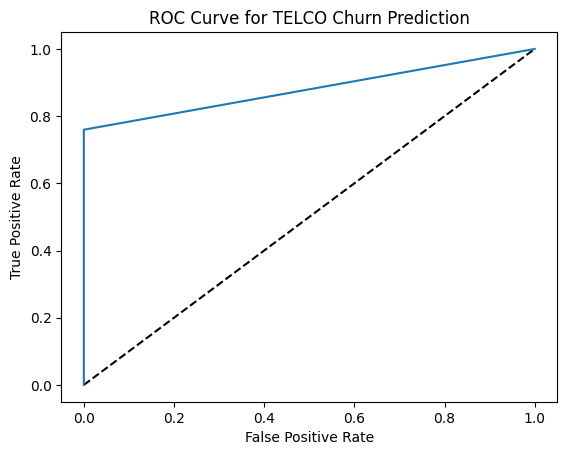

In [37]:
 # Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_cv, y_pred)
    
plt.plot([0, 1], [0, 1], 'k--')
    
# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for TELCO Churn Prediction')
plt.show()

## Gradient Boosting (XGB)

In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', gamma=0,
                    learning_rate=0.01, max_delta_step=0, max_depth=7,
                    n_estimators=500, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=0, scale_pos_weight=1)

In [39]:
xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=7, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [40]:
y_pred_xgb = xgb.predict(x_cv_scaled)

accuracy = accuracy_score(y_cv, y_pred_xgb)
report = classification_report(y_cv, y_pred_xgb)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1043
           1       1.00      1.00      1.00       366

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



In [41]:
roc_auc_score(y_cv, y_pred_xgb)

1.0

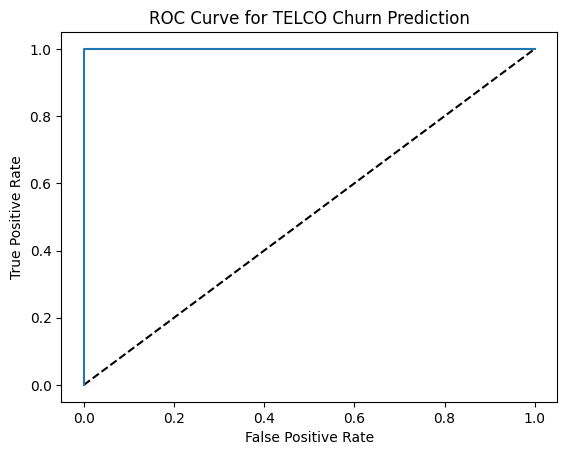

In [42]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_xgb)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for TELCO Churn Prediction')
plt.show()

#### Prediction With Holdout Set

In [43]:
y_pred_test = xgb.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1017
           1       1.00      1.00      1.00       392

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

